In [1]:
import numpy as np
from pathlib import Path
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def preprocess_signals(signals, cutoff, fs):
    filtered_signals = [butter_lowpass_filter(signal, cutoff, fs) for signal in signals]
    normalized_signals = [(signal - np.mean(signal)) / np.std(signal) for signal in filtered_signals]
    return normalized_signals


def make_gravitational_waves(
    path_to_data: Path,
    n_signals: int = 30,
    downsample_factor: int = 2,
    r_min: float = 0.075,
    r_max: float = 0.65,
    n_snr_values: int = 10,
        ):
    def padrand(V, n, kr):
        cut = np.random.randint(n)
        rand1 = np.random.randn(cut)
        rand2 = np.random.randn(n - cut)
        out = np.concatenate((rand1 * kr, V, rand2 * kr))
        return out

    Rcoef = np.linspace(r_min, r_max, n_snr_values)
    Npad = 500  # number of padding points on either side of the vector
    gw = np.load(path_to_data / "gravitational_wave_signals.npy")
    Norig = len(gw["data"][0])
    Ndat = len(gw["signal_present"])
    N = int(Norig / downsample_factor)

    ncoeff = []
    Rcoeflist = []

    for j in range(n_signals):
        ncoeff.append(10 ** (-19) * (1 / Rcoef[j % n_snr_values]))
        Rcoeflist.append(Rcoef[j % n_snr_values])

    noisy_signals = []
    gw_signals = []
    k = 0
    labels = np.zeros(n_signals)

    for j in range(n_signals):
        signal = gw["data"][j % Ndat][range(0, Norig, downsample_factor)]
        sigp = int((np.random.randn() < 0))
        noise = ncoeff[j] * np.random.randn(N)
        labels[j] = sigp
        if sigp == 1:
            rawsig = padrand(signal + noise, Npad, ncoeff[j])
            if k == 0:
                k = 1
        else:
            rawsig = padrand(noise, Npad, ncoeff[j])
        noisy_signals.append(rawsig.copy())
        gw_signals.append(signal)

    # Preprocesar señales
    cutoff = 0.1  # Frecuencia de corte del filtro pasa bajo
    fs = 1.0  # Frecuencia de muestreo (debe ajustarse según tus datos)
    noisy_signals = preprocess_signals(noisy_signals, cutoff, fs)
    gw_signals = preprocess_signals(gw_signals, cutoff, fs)

    return noisy_signals, gw_signals, labels

In [2]:
R = 0.65
n_signals = 1500
DATA = Path(".")

noisy_signals, gw_signals, labels = make_gravitational_waves(
    path_to_data=DATA, n_signals=n_signals, r_min=R, r_max=R, n_snr_values=1
)

print(f"Número de señales con ruido: {len(gw_signals)}")
print(f"Número de pasos en el tiempo por serie: {len(gw_signals[0])}","\n")

Número de señales con ruido: 1500
Número de pasos en el tiempo por serie: 8192 



In [3]:
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# get the index corresponding to the first pure noise time series
background_idx = np.argmin(labels)
# get the index corresponding to the first noise + gravitational wave time series
signal_idx = np.argmax(labels)

ts_noise = noisy_signals[background_idx]
ts_background = noisy_signals[signal_idx]
ts_signal = gw_signals[signal_idx]

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_noise))), y=ts_noise, mode="lines", name="noise"),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=list(range(len(ts_background))),
        y=ts_background,
        mode="lines",
        name="background",
    ),
    row=1,
    col=2,
)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_signal))), y=ts_signal, mode="lines", name="signal"),
    row=1,
    col=2,
)
fig.show()

In [4]:
from gtda.time_series import SingleTakensEmbedding
embedding_dimension = 30
embedding_time_delay = 30
stride = 5

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_gw_embedded = embedder.fit_transform(gw_signals[0])

In [5]:
from sklearn.decomposition import PCA
from gtda.plotting import plot_point_cloud

pca = PCA(n_components=3)
y_gw_embedded_pca = pca.fit_transform(y_gw_embedded)

plot_point_cloud(y_gw_embedded_pca)

In [6]:
embedding_dimension = 30
embedding_time_delay = 30
stride = 5

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_noise_embedded = embedder.fit_transform(noisy_signals[background_idx])

pca = PCA(n_components=3)
y_noise_embedded_pca = pca.fit_transform(y_noise_embedded)

plot_point_cloud(y_noise_embedded_pca)

In [7]:
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram

# Assuming y_gw_embedded_pca is already computed and available
homology_dimensions = [0, 1]  # We compute homology up to the 2nd dimension
vr = VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=1)
diagrams = vr.fit_transform(y_gw_embedded_pca[None, :, :])

# Plot the persistence diagram
plot_diagram(diagrams[0])

In [8]:
# Assuming y_noise_embedded_pca is already computed and available
vr = VietorisRipsPersistence(homology_dimensions=[0, 1], n_jobs=1)
diagrams_noise = vr.fit_transform(y_noise_embedded_pca[None, :, :])

# Plot the persistence diagram for the noise
plot_diagram(diagrams_noise[0])

In [9]:
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.homology import VietorisRipsPersistence
from gtda.metaestimators import CollectionTransformer
from gtda.pipeline import Pipeline
from gtda.time_series import TakensEmbedding

embedding_dimension = 200
embedding_time_delay = 10
stride = 10

embedder = TakensEmbedding(
    time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

# Transformación topológica: Embebido de Takens
embedded_signals = embedder.fit_transform(noisy_signals)

# Cálculo de diagramas de persistencia
persistence = VietorisRipsPersistence(homology_dimensions=[0, 1], n_jobs=-1)
diagrams = persistence.fit_transform(embedded_signals)

# Continuar con el procesamiento de diagramas de persistencia
scaling = Scaler()
entropy = PersistenceEntropy(normalize=True, nan_fill_value=-10)

steps = [("scaling", scaling), ("entropy", entropy)]
topological_transformer = Pipeline(steps)

features = topological_transformer.fit_transform(diagrams)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    features, labels, test_size=0.1, random_state=42
)

In [11]:
from sklearn.metrics import accuracy_score, roc_auc_score


def print_scores(fitted_model):
    res = {
        "Accuracy on train:": accuracy_score(fitted_model.predict(X_train), y_train),
        "ROC AUC on train:": roc_auc_score(
            y_train, fitted_model.predict_proba(X_train)[:, 1]
        ),
        "Accuracy on valid:": accuracy_score(fitted_model.predict(X_valid), y_valid),
        "ROC AUC on valid:": roc_auc_score(
            y_valid, fitted_model.predict_proba(X_valid)[:, 1]
        ),
    }

    for k, v in res.items():
        print(k, round(v, 3))

In [12]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
print_scores(model)

Accuracy on train: 0.73
ROC AUC on train: 0.828
Accuracy on valid: 0.713
ROC AUC on valid: 0.785


In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Convertir las características topológicas a un formato numpy
X = np.array(features)

# Convertir las etiquetas a formato numpy y asegurarse de que son enteros
y = np.array(labels).astype(int)

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir en conjunto de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Convertir las etiquetas a categorías binarias
y_train_categorical = to_categorical(y_train)
y_val_categorical = to_categorical(y_val)

In [15]:
# Definir el modelo CNN
model = Sequential()

# Añadir una capa convolucional
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))

# Aplanar la salida de la capa convolucional
model.add(Flatten())

# Añadir una capa densa con dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Añadir una capa de salida con dos neuronas (para clasificación binaria)
model.add(Dense(2, activation='softmax'))

# Compilar el modelo
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\emili\OneDrive\Documents\RetoTOPO\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [16]:
# Añadir una dimensión adicional a los datos para que sean compatibles con Conv1D
X_train_expanded = np.expand_dims(X_train, axis=2)
X_val_expanded = np.expand_dims(X_val, axis=2)

# Entrenar el modelo
history = model.fit(X_train_expanded, y_train_categorical, epochs=50, batch_size=32, validation_data=(X_val_expanded, y_val_categorical))

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7350 - loss: 0.6152 - val_accuracy: 0.8100 - val_loss: 0.4336
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7718 - loss: 0.4747 - val_accuracy: 0.8233 - val_loss: 0.3880
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7871 - loss: 0.4405 - val_accuracy: 0.8133 - val_loss: 0.3875
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8032 - loss: 0.4080 - val_accuracy: 0.8067 - val_loss: 0.3901
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8211 - loss: 0.4096 - val_accuracy: 0.8000 - val_loss: 0.3882
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8091 - loss: 0.4058 - val_accuracy: 0.8067 - val_loss: 0.3882
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7931 - loss: 0.4248 - val_accuracy: 0.8033 - val_loss: 0.3890
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8043 - loss: 0.4260 - val_accuracy: 0.8067 - val_loss:

In [17]:
# Evaluar el modelo en el conjunto de validación
val_loss, val_accuracy = model.evaluate(X_val_expanded, y_val_categorical, verbose=0)
print(f'Accuracy en el conjunto de validación: {val_accuracy:.4f}')

Accuracy en el conjunto de validación: 0.8000


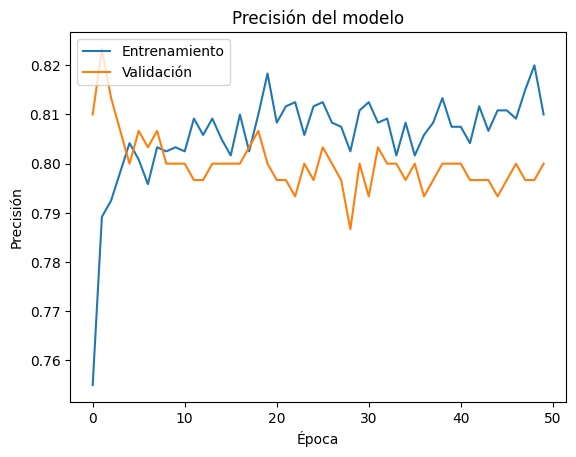

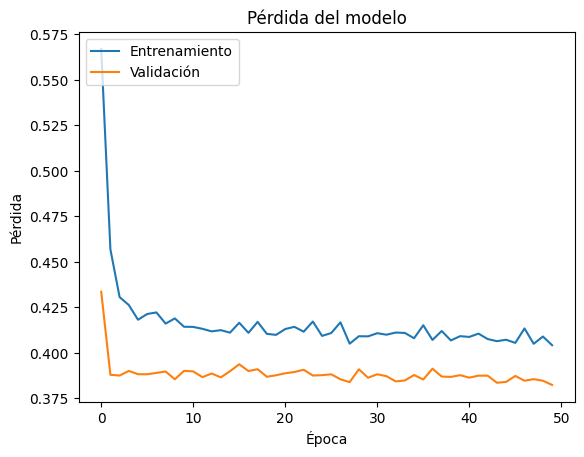

In [18]:
import matplotlib.pyplot as plt

# Visualizar la precisión
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(loc='upper left')
plt.show()

# Visualizar la pérdida
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(loc='upper left')
plt.show()


In [3]:
from scipy.stats import ttest_ind

# Assuming `group1` and `group2` are your data samples
t_stat, p_value = ttest_ind(y_gw_embedded_pca, y_noise_embedded_pca)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

NameError: name 'y_gw_embedded_pca' is not defined